In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
#!pip install --upgrade matplotlib

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import accuracy_score
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import math
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor_kernel
from skimage import color
from scipy import ndimage as ndi
from skimage.measure import shannon_entropy
from scipy.stats import skew, kurtosis
import warnings

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, roc_curve, auc, accuracy_score, classification_report


import seaborn as sns
import random
from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB



def vignette_removal(image: np.ndarray, threshold: int = 50):
    '''
    Automatically crop the image to preserve the main content and eliminate any vignette.
    This process entails evaluating pixel values along the diagonal of the image.

    Args:
    - image (numpy ndarray): The input image to be cropped.
    - threshold (int): The threshold value to differentiate between the image and the vignette.

    Returns:
    - The coordinates of the cropping rectangle and the cropped image.
    '''
    # Find image dimensions
    height, width = image.shape[:2]
    greatest_common_divisor = np.gcd(height, width)

    # Calculate diagonal pixel coordinates
    y_coords = ([i for i in range(0, height, int(height / greatest_common_divisor))], [i for i in range(height - int(height / greatest_common_divisor), 0, -int(height / greatest_common_divisor))])
    x_coords = ([i for i in range(0, width, int(width / greatest_common_divisor))], [i for i in range(0, width, int(width / greatest_common_divisor))])

    # Compute mean pixel values along the diagonal
    coordinates = {'y1_1': 0, 'x1_1': 0, 'y2_1': height, 'x2_1': width, 'y1_2': height, 'x1_2': 0, 'y2_2': 0, 'x2_2': width}
    for i in range(2):
        diagonal_values = []
        y1_aux, x1_aux = 0, 0
        y2_aux, x2_aux = height, width
        for y, x in zip(y_coords[i], x_coords[i]):
            diagonal_values.append(np.mean(image[y, x, :]))

        # Determine the location of the first point where the threshold is crossed
        for idx, value in enumerate(diagonal_values):
            if value >= threshold and idx != 0:  # In the absence of a vignette, the value would be above the threshold at idx=0
                coordinates['y1_' + str(i + 1)] = y_coords[i][idx]
                coordinates['x1_' + str(i + 1)] = x_coords[i][idx]
                break

        # Find the location of the last point where the threshold is crossed
        for idx, value in enumerate(reversed(diagonal_values)):
            if value >= threshold and idx != 0:  # In the absence of a vignette, the value would be above the threshold at idx=0
                coordinates['y2_' + str(i + 1)] = y_coords[i][len(y_coords[i]) - idx]
                coordinates['x2_' + str(i + 1)] = x_coords[i][len(x_coords[i]) - idx]
                break

    # Define the coordinates for cropping the image
    y1 = max(coordinates['y1_1'], coordinates['y2_2'])
    y2 = min(coordinates['y2_1'], coordinates['y1_2'])
    x1 = max(coordinates['x1_1'], coordinates['x1_2'])
    x2 = min(coordinates['x2_1'], coordinates['x2_2'])

    cropped_image = image[y1:y2, x1:x2, :]

    if cropped_image.shape[0] == 0 or cropped_image.shape[1] == 0:
        cropped_image = image

    return cropped_image


def remove_hair(src: np.ndarray, se_size: int = 15):
    '''param : src --> Color image
               se_size --> Size of the structuring elements
      return : Inp --> Inpainted image with hair removed using an alternative method'''

    # Convert the original image to grayscale if it has more than one channel
    if len(src.shape) == 3:
        grayscale = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    else:
        grayscale = src

    # Structuring Element for morphological filtering
    se = cv2.getStructuringElement(1, (se_size, se_size))  # (17x17) '+' shaped SE
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (se_size, se_size))  # (17x17) square-shaped SE

    # Perform morphological blackHat filtering on the grayscale image to detect hair (and other objects) contours
    blackhat = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, se)
    blackhat2 = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, se2)
    enhanced_contours = blackhat + blackhat2

    # Threshold the enhanced contours to create a mask for inpainting
    ret, mask = cv2.threshold(enhanced_contours, 10, 255, cv2.THRESH_BINARY)

    # Inpaint the original image using the mask
    Inpaint = cv2.inpaint(src, mask, 1, cv2.INPAINT_TELEA)

    return Inpaint


# Define the target size for resizing
target_size = (256, 256)
# Function to load and resize images
def load_and_resize_image(file_path):
    img = Image.open(io.BytesIO(file_path))
    img = img.resize(target_size)
    return img

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import multiprocessing


from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, DenseNet169, DenseNet264, DenseNet201

from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2402
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: b6a00ba91f7b6bed11fae2c86217948524f166f6
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.6.6
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visi

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp7u9eo4bi


In [7]:
from zipfile import ZipFile
from google.colab import drive
import os
from tqdm.notebook import tqdm
import numpy as np


In [8]:
import io

# Specify the path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/binarycollab.zip'

# Initialize lists to store data
tr_image_names = []
tr_image_files = []
preprocessed_imgs = []
tr_gtruth = []

# Paths to your image directories within the zip file
tr_nevus = "binarycollab/train/nevus"
tr_others = "binarycollab/train/others"

# Filter out images with empty content

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    valid_nevus_images = [f for f in zip_ref.namelist() if f.startswith(tr_nevus) and zip_ref.read(f)]
    # Process all images in the "nevus" folder
    for nevus_img in tqdm(valid_nevus_images, desc="Nevus"):
      img_content = zip_ref.read(nevus_img)
    # for nevus_img in tqdm([f for f in zip_ref.namelist() if f.startswith(tr_nevus)], desc="Nevus"):
    #   img_content = zip_ref.read(nevus_img)

    # Check if the content is not empty
      if img_content:
        try:
            # Try to open the image

            resized_images = np.array(load_and_resize_image(img_content))
            cropped_img = vignette_removal(resized_images, threshold=50)
            preprocessed_imgs.append(cropped_img)
            tr_image_names.append(nevus_img)
            tr_image_files.append(os.path.join(tr_nevus, nevus_img))
            tr_gtruth.append(0)
        except Exception as e:
            print(f"Error processing image {nevus_img}: {e}")
      else:
        print(f"Empty content for image {nevus_img}")

    # Process all images in the "others" folder
    valid_others_images = [f for f in zip_ref.namelist() if f.startswith(tr_others) and zip_ref.read(f)]
    for others_img in tqdm(valid_others_images, desc="Others"):
      img_content = zip_ref.read(others_img)

    # Check if the content is not empty
      if img_content:
        try:
            # Try to open the image

            resized_images = np.array(load_and_resize_image(img_content))
            cropped_img = vignette_removal(resized_images, threshold=50)
            preprocessed_imgs.append(cropped_img)
            tr_image_names.append(others_img)
            tr_image_files.append(os.path.join(tr_others, others_img))
            tr_gtruth.append(1)
        except Exception as e:
            print(f"Error processing image {others_img}: {e}")
      else:
        print(f"Empty content for image {others_img}")

Nevus:   0%|          | 0/7725 [00:00<?, ?it/s]

Others:   0%|          | 0/7470 [00:00<?, ?it/s]

In [9]:
# Create a dataframe
tr_data = {
    "tr_img_name": tr_image_names,
    "tr_img_file": tr_image_files,
    "preprocessed_images":  preprocessed_imgs,
    "tr_gtruth": tr_gtruth
}

tr_df = pd.DataFrame(tr_data)
tr_df = shuffle(tr_df).reset_index(drop=True)

tr_df.head()

tr_img_name  \
0   binarycollab/train/nevus/nev07579.jpg   
1  binarycollab/train/others/ack00437.jpg   
2   binarycollab/train/nevus/nev04706.jpg   
3  binarycollab/train/others/bkl00388.jpg   
4  binarycollab/train/others/mel00179.jpg   

                                         tr_img_file  \
0  binarycollab/train/nevus/binarycollab/train/ne...   
1  binarycollab/train/others/binarycollab/train/o...   
2  binarycollab/train/nevus/binarycollab/train/ne...   
3  binarycollab/train/others/binarycollab/train/o...   
4  binarycollab/train/others/binarycollab/train/o...   

                                 preprocessed_images  tr_gtruth  
0  [[[209, 213, 214], [209, 213, 215], [209, 213,...          0  
1  [[[53, 45, 52], [61, 50, 57], [65, 53, 60], [6...          1  
2  [[[148, 129, 110], [146, 124, 105], [147, 124,...          0  
3  [[[120, 84, 24], [119, 83, 23], [119, 82, 23],...          1  
4  [[[204, 195, 188], [204, 195, 189], [205, 196,...          1

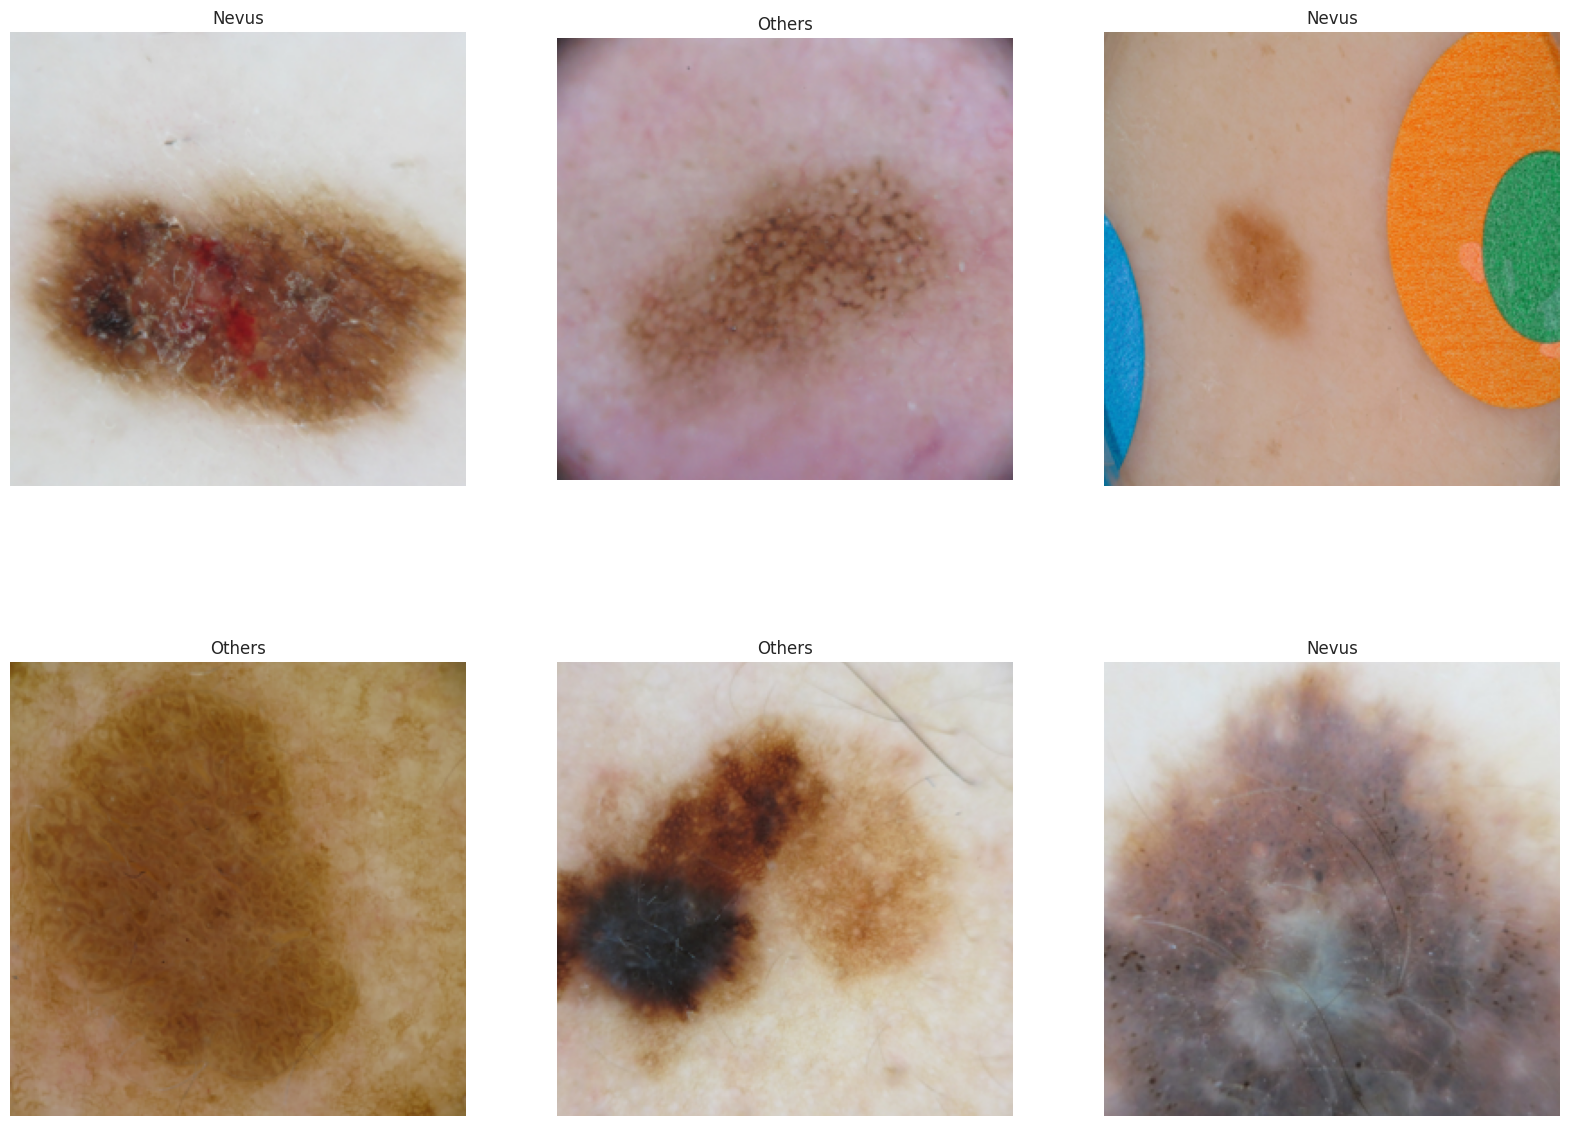

In [10]:
# Set the seaborn style
sns.set_style("white")

# Create a figure
plt.figure(figsize=[20, 15])

for i, (image_path, ground_truth) in enumerate(zip(tr_df["preprocessed_images"][:6], tr_df["tr_gtruth"][:6])):
    # Set the title based on ground truth
    title = "Nevus" if ground_truth == 0 else "Others"

    # Plot the image
    plt.subplot(2, 3, i + 1)
    plt.imshow(image_path)
    plt.axis("off")
    plt.title(title)
plt.show()

In [12]:
# def split_data(data, labels, val_frac, random_seed=None):
#   length = len(data)
#   indices = list(range(length))

#   if random_seed is not None:
#     np.random.seed(random_seed)

#   np.random.shuffle(indices)

#   val_split = int(val_frac * length)

#   val_indices = indices[:val_split]
#   train_indices = indices[val_split:]

#   train_data = [data[i] for i in train_indices]
#   train_labels = [labels[i] for i in train_indices]
#   val_data = [data[i] for i in val_indices]
#   val_labels = [labels[i] for i in val_indices]

#   return (
#       train_data, train_labels,
#       val_data, val_labels
#       )

In [11]:

# Extract data and labels
data = tr_df['preprocessed_images'].values
labels = tr_df['tr_gtruth'].values

# # Split the data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(data, labels, test_size=0.2, random_state=42)

# Use the split_data function
# train_x, train_y, val_x, val_y = split_data(
#     data, labels, val_frac=0.2, random_seed=42
# )

# Print the size of the resulting sets
print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}")

Training count: 12156, Validation count: 3039


In [12]:
# Initialize lists to store validation data
val_image_names = []
val_image_files = []
val_preprocessed_imgs = []
val_gtruth = []

# Paths to your image directories within the zip file
val_nevus = "binarycollab/val/nevus"
val_others = "binarycollab/val/others"

# Filter out images with empty content

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    val_valid_nevus_images = [f for f in zip_ref.namelist() if f.startswith(val_nevus) and zip_ref.read(f)]
    # Process all images in the "nevus" folder
    for val_nevus_img in tqdm(val_valid_nevus_images, desc="Nevus"):
      val_img_content = zip_ref.read(val_nevus_img)

    # Check if the content is not empty
      if val_img_content:
        try:
            # Try to open the image

            val_resized_images = np.array(load_and_resize_image(val_img_content))
            val_cropped_img = vignette_removal(val_resized_images, threshold=50)
            val_preprocessed_imgs.append(val_cropped_img)
            val_image_names.append(val_nevus_img)
            val_image_files.append(os.path.join(val_nevus, val_nevus_img))
            val_gtruth.append(0)
        except Exception as e:
            print(f"Error processing image {val_nevus_img}: {e}")
      else:
        print(f"Empty content for image {val_nevus_img}")

    # Process all images in the "others" folder
    val_valid_others_images = [f for f in zip_ref.namelist() if f.startswith(val_others) and zip_ref.read(f)]
    for val_others_img in tqdm(val_valid_others_images, desc="Others"):
      val_img_content = zip_ref.read(val_others_img)

    # Check if the content is not empty
      if val_img_content:
        try:
            # Try to open the image

            val_resized_images = np.array(load_and_resize_image(val_img_content))
            val_cropped_img = vignette_removal(val_resized_images, threshold=50)
            val_preprocessed_imgs.append(val_cropped_img)
            val_image_names.append(val_others_img)
            val_image_files.append(os.path.join(val_others, val_others_img))
            val_gtruth.append(1)
        except Exception as e:
            print(f"Error processing image {val_others_img}: {e}")
      else:
        print(f"Empty content for image {val_others_img}")

Nevus:   0%|          | 0/1931 [00:00<?, ?it/s]

Others:   0%|          | 0/1865 [00:00<?, ?it/s]

In [13]:
# Create a dataframe
val_data = {
    "val_img_name": val_image_names,
    "val_img_file": val_image_files,
    "val_preprocessed_images": val_preprocessed_imgs,
    "val_gtruth": val_gtruth
}

val_df = pd.DataFrame(val_data)
val_df = shuffle(val_df).reset_index(drop=True)

val_df.head()

val_img_name  \
0  binarycollab/val/others/bcc02432.jpg   
1  binarycollab/val/others/mel03299.jpg   
2   binarycollab/val/nevus/nev09499.jpg   
3   binarycollab/val/nevus/nev09619.jpg   
4  binarycollab/val/others/mel02937.jpg   

                                        val_img_file  \
0  binarycollab/val/others/binarycollab/val/other...   
1  binarycollab/val/others/binarycollab/val/other...   
2  binarycollab/val/nevus/binarycollab/val/nevus/...   
3  binarycollab/val/nevus/binarycollab/val/nevus/...   
4  binarycollab/val/others/binarycollab/val/other...   

                             val_preprocessed_images  val_gtruth  
0  [[[157, 168, 172], [158, 167, 172], [158, 167,...           1  
1  [[[55, 53, 64], [60, 59, 66], [66, 66, 73], [7...           1  
2  [[[60, 56, 51], [74, 69, 61], [91, 83, 80], [1...           0  
3  [[[156, 143, 163], [154, 143, 160], [151, 139,...           0  
4  [[[153, 109, 104], [154, 110, 107], [151, 107,...           1

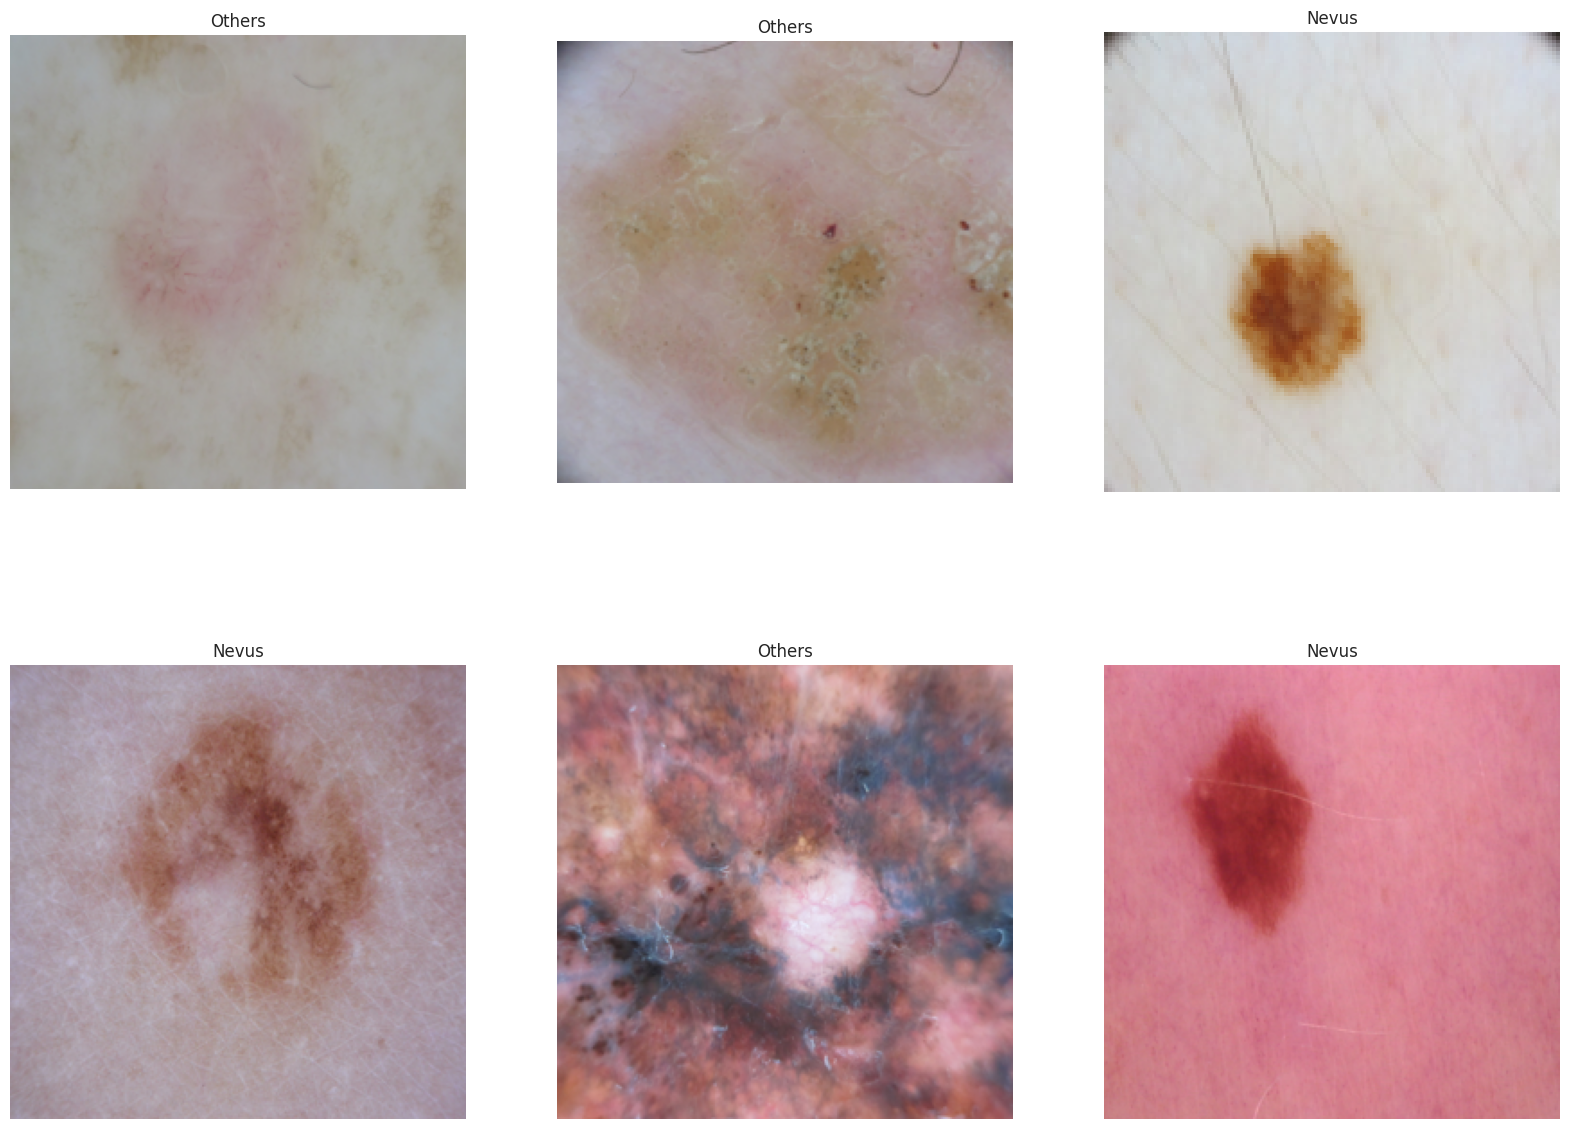

In [14]:
# Set the seaborn style
sns.set_style("white")

# Create a figure
plt.figure(figsize=[20, 15])

for i, (val_image_path, val_ground_truth) in enumerate(zip(val_df["val_preprocessed_images"][:6], val_df["val_gtruth"][:6])):
    # Set the title based on ground truth
    val_title = "Nevus" if val_ground_truth == 0 else "Others"

    # Plot the image
    plt.subplot(2, 3, i + 1)
    plt.imshow(val_image_path)
    plt.axis("off")
    plt.title(val_title)

plt.show()

In [ ]:
# def organize_data(data, labels, random_seed=None):
#     length = len(data)
#     indices = list(range(length))

#     if random_seed is not None:
#         np.random.seed(random_seed)

#     np.random.shuffle(indices)

#     organized_data = [data[i] for i in indices]
#     organized_labels = [labels[i] for i in indices] if labels is not None else None

#     return organized_data, organized_labels


In [15]:
# Extract data and labels
val_data = val_df['val_preprocessed_images'].values
val_labels = val_df['val_gtruth'].values


#unseen_val_x, unseen_val_y, _, _ = split_data(val_data, val_labels, val_frac = 0)

# Print the size of the resulting sets
print(f"Training count: {len(val_data)}, Label count: {len(val_labels)}")

Training count: 3796, Label count: 3796


In [ ]:
# # Normalize the images and convert to numpy array
# unseen_val_x = val_df['val_preprocessed_images'].apply(lambda x: np.asarray(x) / 255.).to_numpy()

# # Convert the list of labels to a numpy array
# unseen_val_y = val_df['val_gtruth'].to_numpy()

# # Display the shapes of the resulting arrays
# print("Unseen Validation X shape:", unseen_val_x.shape)
# print("Unseen Validation Y shape:", unseen_val_y.shape)

Unseen Validation X shape: (3796,)
Unseen Validation Y shape: (3796,)


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [16]:
num_class = 2

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [17]:
import numpy as np
import torch

def custom_collate(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Assuming your images are in HWC format (height, width, channels)
    max_height = max(image.shape[0] for image in data)
    max_width = max(image.shape[1] for image in data)

    # Padding images to the maximum size in the batch
    padded_data = [np.pad(image, ((0, max_height - image.shape[0]), (0, max_width - image.shape[1]), (0, 0)), mode='constant') for image in data]

    # Convert the padded_data list to a torch tensor
    data_tensor = torch.stack([torch.from_numpy(image.astype(np.float32).transpose((2, 0, 1))) for image in padded_data])

    # Convert labels to a torch tensor
    labels_tensor = torch.tensor(labels)

    return data_tensor, labels_tensor


In [18]:
class SkinDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels):
        self.image_files = image_files
        self.labels = labels


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.image_files[index], self.labels[index]


# Create validation dataset and data loader
train_ds = SkinDataset(train_x, train_y)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=custom_collate)


val_ds = SkinDataset(val_x, val_y)
val_loader = DataLoader(val_ds, batch_size=64, collate_fn=custom_collate)

actual_val_ds = SkinDataset(val_data, val_labels)
actual_val_loader = DataLoader(actual_val_ds, batch_size=64, shuffle=False, collate_fn=custom_collate)

Define network and optimizer

# DenseNet121

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 10
val_interval = 1
auc_metric = ROCAUCMetric()

Model training

In [36]:
import os

val_interval = 1  # Validation interval in epochs

best_accuracy = -1
best_accuracy_epoch = -1
epoch_loss_values = []
accuracy_values = []

# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0

    # Use tqdm for a progress bar
    progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{max_epochs}", unit="batch", total=len(train_loader))
    for step, batch_data in progress_bar:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # Explicitly convert inputs to torch.float and move to device
        inputs = inputs.to(torch.float).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(train_loss=f"{loss.item():.4f}")

    epoch_loss /= step + 1
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in tqdm(val_loader, desc=f"Validation", unit="batch"):
                val_images, val_labels = val_data[0].to(device).to(torch.float), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            accuracy_value = torch.eq(y_pred.argmax(dim=1), y)
            accuracy_metric = accuracy_value.sum().item() / len(accuracy_value)
            accuracy_values.append(accuracy_metric)

            if accuracy_metric > best_accuracy:
                best_accuracy = accuracy_metric
                best_accuracy_epoch = epoch + 1
                save_path = os.path.join(root_dir, "best_accuracy_model.hdf5")
                torch.save(model.state_dict(), save_path)
                print(f"saved new best accuracy model at: {save_path}")

            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy_metric:.4f}"
                f" best accuracy: {best_accuracy:.4f}"
                f" at epoch: {best_accuracy_epoch}"
            )


----------
epoch 1/10


Epoch 1/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 1 average loss: 0.5682


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/best_accuracy_model.hdf5
current epoch: 1 current accuracy: 0.7272 best accuracy: 0.7272 at epoch: 1
----------
epoch 2/10


Epoch 2/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 2 average loss: 0.5279


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/best_accuracy_model.hdf5
current epoch: 2 current accuracy: 0.7433 best accuracy: 0.7433 at epoch: 2
----------
epoch 3/10


Epoch 3/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 3 average loss: 0.5099


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/best_accuracy_model.hdf5
current epoch: 3 current accuracy: 0.7529 best accuracy: 0.7529 at epoch: 3
----------
epoch 4/10


Epoch 4/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 4 average loss: 0.4967


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/best_accuracy_model.hdf5
current epoch: 4 current accuracy: 0.7611 best accuracy: 0.7611 at epoch: 4
----------
epoch 5/10


Epoch 5/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 5 average loss: 0.4787


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/best_accuracy_model.hdf5
current epoch: 5 current accuracy: 0.7766 best accuracy: 0.7766 at epoch: 5
----------
epoch 6/10


Epoch 6/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 6 average loss: 0.4626


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/best_accuracy_model.hdf5
current epoch: 6 current accuracy: 0.7881 best accuracy: 0.7881 at epoch: 6
----------
epoch 7/10


Epoch 7/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 7 average loss: 0.4485


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 7 current accuracy: 0.7792 best accuracy: 0.7881 at epoch: 6
----------
epoch 8/10


Epoch 8/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 8 average loss: 0.4347


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/best_accuracy_model.hdf5
current epoch: 8 current accuracy: 0.7894 best accuracy: 0.7894 at epoch: 8
----------
epoch 9/10


Epoch 9/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 9 average loss: 0.4207


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/best_accuracy_model.hdf5
current epoch: 9 current accuracy: 0.7920 best accuracy: 0.7920 at epoch: 9
----------
epoch 10/10


Epoch 10/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 10 average loss: 0.4036


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 10 current accuracy: 0.7855 best accuracy: 0.7920 at epoch: 9



Plot the loss and metric

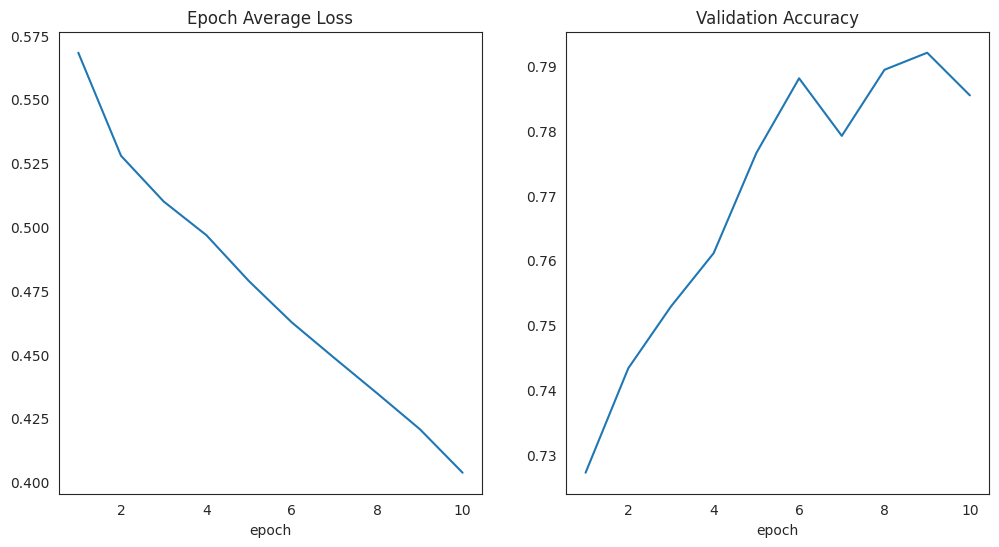

In [37]:
plt.figure("train", (12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x_train = [i + 1 for i in range(len(epoch_loss_values))]
y_train = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x_train, y_train)

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.title("Validation Accuracy")
x_val = [val_interval * (i + 1) for i in range(len(accuracy_values))]
y_val = accuracy_values
plt.xlabel("epoch")
plt.plot(x_val, y_val)

plt.show()


Evaluate the model on validation dataset

In [38]:
# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

# Instantiate the DenseNet121 model
model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)

# Load the saved model
saved_model_path = os.path.join(root_dir, "best_metric_model.hdf5")
model.load_state_dict(torch.load(saved_model_path))
model.to(device)
model.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Perform predictions on the actual_val_loader
with torch.no_grad():
    for actual_val_data in actual_val_loader:
        actual_val_images, actual_val_labels = (
            actual_val_data[0].to(device),
            actual_val_data[1].to(device),
        )

        # Convert input images to torch.cuda.FloatTensor
        actual_val_images = actual_val_images.to(torch.float32)

        # Forward pass
        outputs = model(actual_val_images)

        # Collect true labels and predicted labels
        y_true.extend(actual_val_labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# Calculate accuracy
accuracy1 = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy1)

Accuracy: 0.7581664910432033


              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1931
           1       0.73      0.80      0.76      1865

    accuracy                           0.76      3796
   macro avg       0.76      0.76      0.76      3796
weighted avg       0.76      0.76      0.76      3796



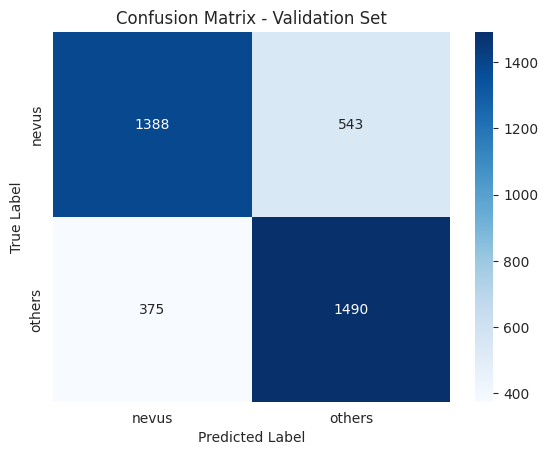

In [39]:
print(classification_report(y_true, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# DenseNet169

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet169(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 10
val_interval = 1
auc_metric = ROCAUCMetric()

In [21]:
val_interval = 1  # Validation interval in epochs

best_accuracy = -1
best_accuracy_epoch = -1
epoch_loss_values = []
accuracy_values = []

# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0

    # Use tqdm for a progress bar
    progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{max_epochs}", unit="batch", total=len(train_loader))
    for step, batch_data in progress_bar:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # Explicitly convert inputs to torch.float and move to device
        inputs = inputs.to(torch.float).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(train_loss=f"{loss.item():.4f}")

    epoch_loss /= step + 1
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in tqdm(val_loader, desc=f"Validation", unit="batch"):
                val_images, val_labels = val_data[0].to(device).to(torch.float), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            accuracy_value = torch.eq(y_pred.argmax(dim=1), y)
            accuracy_metric = accuracy_value.sum().item() / len(accuracy_value)
            accuracy_values.append(accuracy_metric)

            if accuracy_metric > best_accuracy:
                best_accuracy = accuracy_metric
                best_accuracy_epoch = epoch + 1
                save_path = os.path.join(root_dir, "DenseNet169best_accuracy_model.hdf5")
                torch.save(model.state_dict(), save_path)
                print(f"saved new best accuracy model at: {save_path}")

            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy_metric:.4f}"
                f" best accuracy: {best_accuracy:.4f}"
                f" at epoch: {best_accuracy_epoch}"
            )


----------
epoch 1/10


Epoch 1/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 1 average loss: 0.5668


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169best_accuracy_model.hdf5
current epoch: 1 current accuracy: 0.7229 best accuracy: 0.7229 at epoch: 1
----------
epoch 2/10


Epoch 2/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 2 average loss: 0.5192


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169best_accuracy_model.hdf5
current epoch: 2 current accuracy: 0.7361 best accuracy: 0.7361 at epoch: 2
----------
epoch 3/10


Epoch 3/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 3 average loss: 0.5002


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169best_accuracy_model.hdf5
current epoch: 3 current accuracy: 0.7545 best accuracy: 0.7545 at epoch: 3
----------
epoch 4/10


Epoch 4/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 4 average loss: 0.4817


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169best_accuracy_model.hdf5
current epoch: 4 current accuracy: 0.7595 best accuracy: 0.7595 at epoch: 4
----------
epoch 5/10


Epoch 5/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 5 average loss: 0.4680


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169best_accuracy_model.hdf5
current epoch: 5 current accuracy: 0.7733 best accuracy: 0.7733 at epoch: 5
----------
epoch 6/10


Epoch 6/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 6 average loss: 0.4458


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169best_accuracy_model.hdf5
current epoch: 6 current accuracy: 0.7743 best accuracy: 0.7743 at epoch: 6
----------
epoch 7/10


Epoch 7/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 7 average loss: 0.4329


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 7 current accuracy: 0.7716 best accuracy: 0.7743 at epoch: 6
----------
epoch 8/10


Epoch 8/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 8 average loss: 0.4123


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169best_accuracy_model.hdf5
current epoch: 8 current accuracy: 0.7832 best accuracy: 0.7832 at epoch: 8
----------
epoch 9/10


Epoch 9/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 9 average loss: 0.3910


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 9 current accuracy: 0.7795 best accuracy: 0.7832 at epoch: 8
----------
epoch 10/10


Epoch 10/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 10 average loss: 0.3695


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169best_accuracy_model.hdf5
current epoch: 10 current accuracy: 0.7868 best accuracy: 0.7868 at epoch: 10


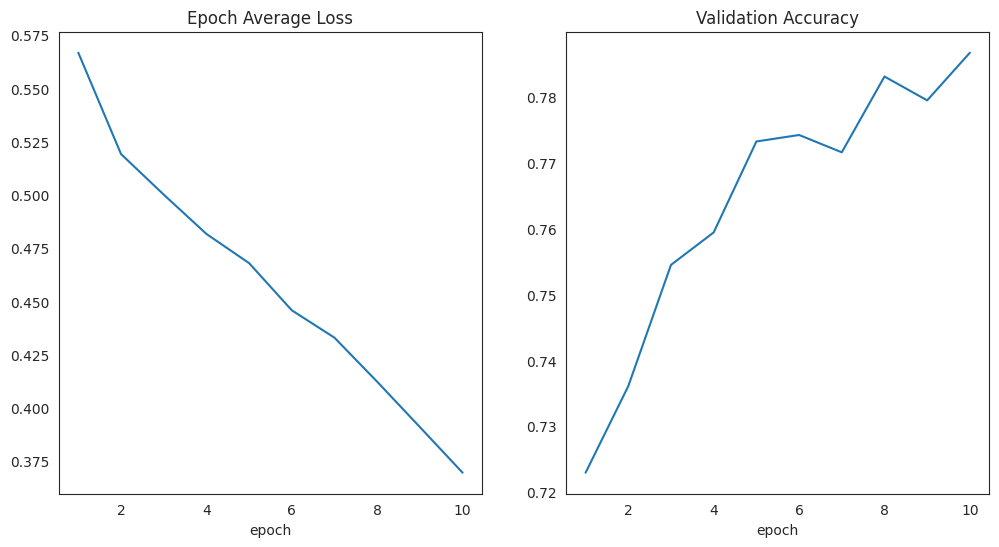

In [22]:
plt.figure("train", (12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x_train = [i + 1 for i in range(len(epoch_loss_values))]
y_train = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x_train, y_train)

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.title("Validation Accuracy")
x_val = [val_interval * (i + 1) for i in range(len(accuracy_values))]
y_val = accuracy_values
plt.xlabel("epoch")
plt.plot(x_val, y_val)

plt.show()


In [24]:
# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

# Instantiate the DenseNet121 model
model = DenseNet169(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)

# Load the saved model
saved_model_path = os.path.join(root_dir, "DenseNet169best_accuracy_model.hdf5")
model.load_state_dict(torch.load(saved_model_path))
model.to(device)
model.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Perform predictions on the actual_val_loader
with torch.no_grad():
    for actual_val_data in actual_val_loader:
        actual_val_images, actual_val_labels = (
            actual_val_data[0].to(device),
            actual_val_data[1].to(device),
        )

        # Convert input images to torch.cuda.FloatTensor
        actual_val_images = actual_val_images.to(torch.float32)

        # Forward pass
        outputs = model(actual_val_images)

        # Collect true labels and predicted labels
        y_true.extend(actual_val_labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# Calculate accuracy
accuracy1 = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy1)

Accuracy: 0.7881981032665965


              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1931
           1       0.79      0.78      0.78      1865

    accuracy                           0.79      3796
   macro avg       0.79      0.79      0.79      3796
weighted avg       0.79      0.79      0.79      3796



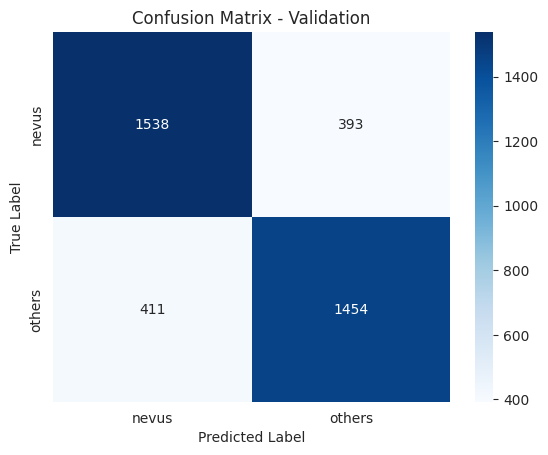

In [26]:
print(classification_report(y_true, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation')
plt.show()

# DenseNet201

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet201(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 10
val_interval = 1
auc_metric = ROCAUCMetric()

In [29]:
val_interval = 1  # Validation interval in epochs

best_accuracy = -1
best_accuracy_epoch = -1
epoch_loss_values = []
accuracy_values = []

# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0

    # Use tqdm for a progress bar
    progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{max_epochs}", unit="batch", total=len(train_loader))
    for step, batch_data in progress_bar:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # Explicitly convert inputs to torch.float and move to device
        inputs = inputs.to(torch.float).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(train_loss=f"{loss.item():.4f}")

    epoch_loss /= step + 1
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in tqdm(val_loader, desc=f"Validation", unit="batch"):
                val_images, val_labels = val_data[0].to(device).to(torch.float), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            accuracy_value = torch.eq(y_pred.argmax(dim=1), y)
            accuracy_metric = accuracy_value.sum().item() / len(accuracy_value)
            accuracy_values.append(accuracy_metric)

            if accuracy_metric > best_accuracy:
                best_accuracy = accuracy_metric
                best_accuracy_epoch = epoch + 1
                save_path = os.path.join(root_dir, "DenseNet201best_accuracy_model.hdf5")
                torch.save(model.state_dict(), save_path)
                print(f"saved new best accuracy model at: {save_path}")

            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy_metric:.4f}"
                f" best accuracy: {best_accuracy:.4f}"
                f" at epoch: {best_accuracy_epoch}"
            )


----------
epoch 1/10


Epoch 1/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 1 average loss: 0.5466


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet201best_accuracy_model.hdf5
current epoch: 1 current accuracy: 0.7374 best accuracy: 0.7374 at epoch: 1
----------
epoch 2/10


Epoch 2/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 2 average loss: 0.5117


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet201best_accuracy_model.hdf5
current epoch: 2 current accuracy: 0.7387 best accuracy: 0.7387 at epoch: 2
----------
epoch 3/10


Epoch 3/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 3 average loss: 0.4898


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet201best_accuracy_model.hdf5
current epoch: 3 current accuracy: 0.7585 best accuracy: 0.7585 at epoch: 3
----------
epoch 4/10


Epoch 4/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 4 average loss: 0.4680


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet201best_accuracy_model.hdf5
current epoch: 4 current accuracy: 0.7753 best accuracy: 0.7753 at epoch: 4
----------
epoch 5/10


Epoch 5/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 5 average loss: 0.4456


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 5 current accuracy: 0.7683 best accuracy: 0.7753 at epoch: 4
----------
epoch 6/10


Epoch 6/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 6 average loss: 0.4315


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 6 current accuracy: 0.7739 best accuracy: 0.7753 at epoch: 4
----------
epoch 7/10


Epoch 7/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 7 average loss: 0.4135


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 7 current accuracy: 0.7746 best accuracy: 0.7753 at epoch: 4
----------
epoch 8/10


Epoch 8/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 8 average loss: 0.3881


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 8 current accuracy: 0.7562 best accuracy: 0.7753 at epoch: 4
----------
epoch 9/10


Epoch 9/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 9 average loss: 0.3764


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 9 current accuracy: 0.7753 best accuracy: 0.7753 at epoch: 4
----------
epoch 10/10


Epoch 10/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 10 average loss: 0.3448


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 10 current accuracy: 0.7687 best accuracy: 0.7753 at epoch: 4


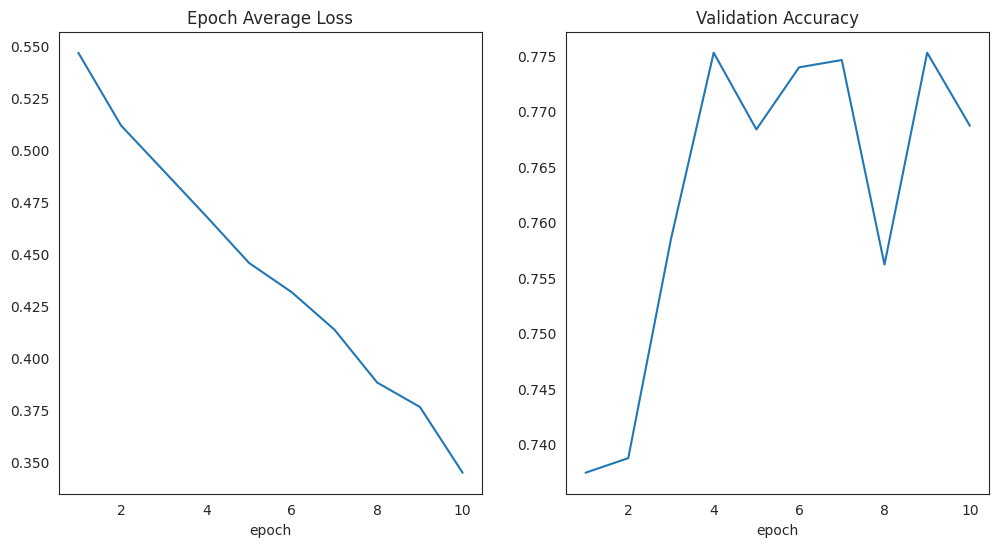

In [30]:
plt.figure("train", (12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x_train = [i + 1 for i in range(len(epoch_loss_values))]
y_train = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x_train, y_train)

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.title("Validation Accuracy")
x_val = [val_interval * (i + 1) for i in range(len(accuracy_values))]
y_val = accuracy_values
plt.xlabel("epoch")
plt.plot(x_val, y_val)

plt.show()


Accuracy: 0.7689673340358272
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1931
           1       0.74      0.81      0.78      1865

    accuracy                           0.77      3796
   macro avg       0.77      0.77      0.77      3796
weighted avg       0.77      0.77      0.77      3796



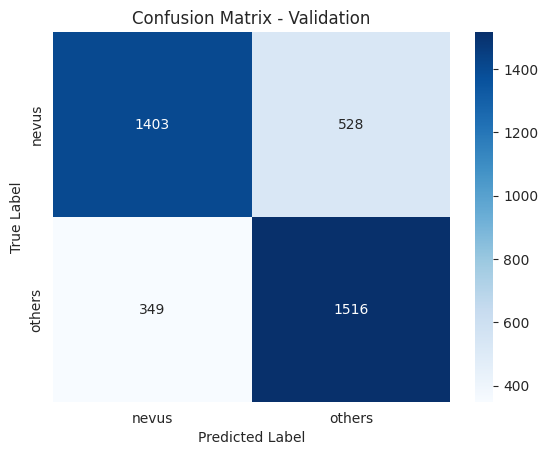

In [45]:
# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

# Instantiate the DenseNet121 model
model = DenseNet201(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)

# Load the saved model
saved_model_path = os.path.join(root_dir, "DenseNet201best_accuracy_model.hdf5")
model.load_state_dict(torch.load(saved_model_path))
model.to(device)
model.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Perform predictions on the actual_val_loader
with torch.no_grad():
    for actual_val_data in actual_val_loader:
        actual_val_images, actual_val_labels = (
            actual_val_data[0].to(device),
            actual_val_data[1].to(device),
        )

        # Convert input images to torch.cuda.FloatTensor
        actual_val_images = actual_val_images.to(torch.float32)

        # Forward pass
        outputs = model(actual_val_images)

        # Collect true labels and predicted labels
        y_true.extend(actual_val_labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# Calculate accuracy
accuracy1 = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy1)

print(classification_report(y_true, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation')
plt.show()

# DenseNet264

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet264(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 10
val_interval = 1
auc_metric = ROCAUCMetric()

In [34]:
val_interval = 1  # Validation interval in epochs

best_accuracy = -1
best_accuracy_epoch = -1
epoch_loss_values = []
accuracy_values = []

# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0

    # Use tqdm for a progress bar
    progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{max_epochs}", unit="batch", total=len(train_loader))
    for step, batch_data in progress_bar:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # Explicitly convert inputs to torch.float and move to device
        inputs = inputs.to(torch.float).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(train_loss=f"{loss.item():.4f}")

    epoch_loss /= step + 1
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in tqdm(val_loader, desc=f"Validation", unit="batch"):
                val_images, val_labels = val_data[0].to(device).to(torch.float), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            accuracy_value = torch.eq(y_pred.argmax(dim=1), y)
            accuracy_metric = accuracy_value.sum().item() / len(accuracy_value)
            accuracy_values.append(accuracy_metric)

            if accuracy_metric > best_accuracy:
                best_accuracy = accuracy_metric
                best_accuracy_epoch = epoch + 1
                save_path = os.path.join(root_dir, "DenseNet264best_accuracy_model.hdf5")
                torch.save(model.state_dict(), save_path)
                print(f"saved new best accuracy model at: {save_path}")

            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy_metric:.4f}"
                f" best accuracy: {best_accuracy:.4f}"
                f" at epoch: {best_accuracy_epoch}"
            )


----------
epoch 1/10


Epoch 1/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 1 average loss: 0.5396


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet264best_accuracy_model.hdf5
current epoch: 1 current accuracy: 0.7387 best accuracy: 0.7387 at epoch: 1
----------
epoch 2/10


Epoch 2/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 2 average loss: 0.4969


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet264best_accuracy_model.hdf5
current epoch: 2 current accuracy: 0.7499 best accuracy: 0.7499 at epoch: 2
----------
epoch 3/10


Epoch 3/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 3 average loss: 0.4745


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet264best_accuracy_model.hdf5
current epoch: 3 current accuracy: 0.7628 best accuracy: 0.7628 at epoch: 3
----------
epoch 4/10


Epoch 4/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 4 average loss: 0.4550


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet264best_accuracy_model.hdf5
current epoch: 4 current accuracy: 0.7706 best accuracy: 0.7706 at epoch: 4
----------
epoch 5/10


Epoch 5/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 5 average loss: 0.4329


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 5 current accuracy: 0.7667 best accuracy: 0.7706 at epoch: 4
----------
epoch 6/10


Epoch 6/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 6 average loss: 0.4125


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet264best_accuracy_model.hdf5
current epoch: 6 current accuracy: 0.7766 best accuracy: 0.7766 at epoch: 6
----------
epoch 7/10


Epoch 7/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 7 average loss: 0.3964


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 7 current accuracy: 0.7756 best accuracy: 0.7766 at epoch: 6
----------
epoch 8/10


Epoch 8/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 8 average loss: 0.3732


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet264best_accuracy_model.hdf5
current epoch: 8 current accuracy: 0.7815 best accuracy: 0.7815 at epoch: 8
----------
epoch 9/10


Epoch 9/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 9 average loss: 0.3507


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 9 current accuracy: 0.7634 best accuracy: 0.7815 at epoch: 8
----------
epoch 10/10


Epoch 10/10:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 10 average loss: 0.3286


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 10 current accuracy: 0.7706 best accuracy: 0.7815 at epoch: 8


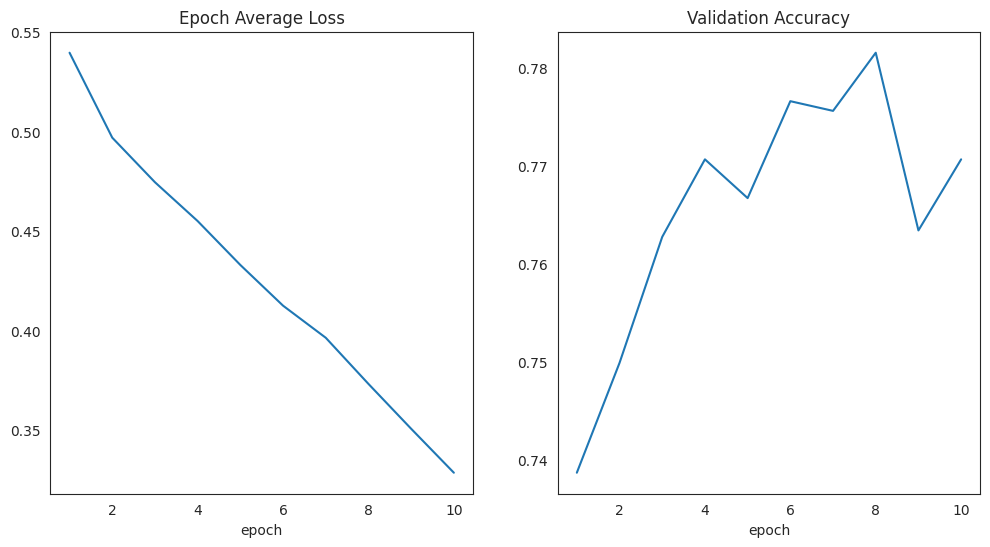

In [35]:
plt.figure("train", (12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x_train = [i + 1 for i in range(len(epoch_loss_values))]
y_train = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x_train, y_train)

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.title("Validation Accuracy")
x_val = [val_interval * (i + 1) for i in range(len(accuracy_values))]
y_val = accuracy_values
plt.xlabel("epoch")
plt.plot(x_val, y_val)

plt.show()


Accuracy: 0.78609062170706
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1931
           1       0.76      0.83      0.79      1865

    accuracy                           0.79      3796
   macro avg       0.79      0.79      0.79      3796
weighted avg       0.79      0.79      0.79      3796



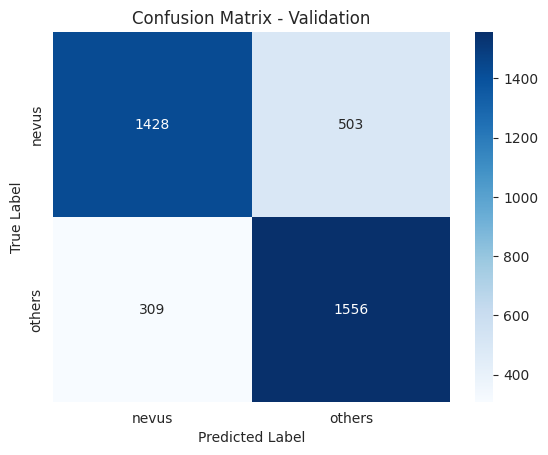

In [37]:
# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

# Instantiate the DenseNet121 model
model = DenseNet264(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)

# Load the saved model
saved_model_path = os.path.join(root_dir, "DenseNet264best_accuracy_model.hdf5")
model.load_state_dict(torch.load(saved_model_path))
model.to(device)
model.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Perform predictions on the actual_val_loader
with torch.no_grad():
    for actual_val_data in actual_val_loader:
        actual_val_images, actual_val_labels = (
            actual_val_data[0].to(device),
            actual_val_data[1].to(device),
        )

        # Convert input images to torch.cuda.FloatTensor
        actual_val_images = actual_val_images.to(torch.float32)

        # Forward pass
        outputs = model(actual_val_images)

        # Collect true labels and predicted labels
        y_true.extend(actual_val_labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# Calculate accuracy
accuracy1 = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy1)

print(classification_report(y_true, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation')
plt.show()

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet169(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()


In [49]:

val_interval = 1  # Validation interval in epochs

best_accuracy = -1
best_accuracy_epoch = -1
epoch_loss_values = []
accuracy_values = []

# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0

    # Use tqdm for a progress bar
    progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{max_epochs}", unit="batch", total=len(train_loader))
    for step, batch_data in progress_bar:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # Explicitly convert inputs to torch.float and move to device
        inputs = inputs.to(torch.float).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(train_loss=f"{loss.item():.4f}")

    epoch_loss /= step + 1
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in tqdm(val_loader, desc=f"Validation", unit="batch"):
                val_images, val_labels = val_data[0].to(device).to(torch.float), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            accuracy_value = torch.eq(y_pred.argmax(dim=1), y)
            accuracy_metric = accuracy_value.sum().item() / len(accuracy_value)
            accuracy_values.append(accuracy_metric)

            if accuracy_metric > best_accuracy:
                best_accuracy = accuracy_metric
                best_accuracy_epoch = epoch + 1
                save_path = os.path.join(root_dir, "DenseNet169_100_best_accuracy_model.hdf5")
                torch.save(model.state_dict(), save_path)
                print(f"saved new best accuracy model at: {save_path}")

            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy_metric:.4f}"
                f" best accuracy: {best_accuracy:.4f}"
                f" at epoch: {best_accuracy_epoch}"
            )


----------
epoch 1/100


Epoch 1/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 1 average loss: 0.5680


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 1 current accuracy: 0.7177 best accuracy: 0.7177 at epoch: 1
----------
epoch 2/100


Epoch 2/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 2 average loss: 0.5189


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 2 current accuracy: 0.7460 best accuracy: 0.7460 at epoch: 2
----------
epoch 3/100


Epoch 3/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 3 average loss: 0.4985


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 3 current accuracy: 0.7526 best accuracy: 0.7526 at epoch: 3
----------
epoch 4/100


Epoch 4/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 4 average loss: 0.4784


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 4 current accuracy: 0.7604 best accuracy: 0.7604 at epoch: 4
----------
epoch 5/100


Epoch 5/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 5 average loss: 0.4583


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 5 current accuracy: 0.7660 best accuracy: 0.7660 at epoch: 5
----------
epoch 6/100


Epoch 6/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 6 average loss: 0.4428


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 6 current accuracy: 0.7766 best accuracy: 0.7766 at epoch: 6
----------
epoch 7/100


Epoch 7/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 7 average loss: 0.4221


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 7 current accuracy: 0.7706 best accuracy: 0.7766 at epoch: 6
----------
epoch 8/100


Epoch 8/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 8 average loss: 0.4034


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 8 current accuracy: 0.7838 best accuracy: 0.7838 at epoch: 8
----------
epoch 9/100


Epoch 9/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 9 average loss: 0.3836


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 9 current accuracy: 0.7730 best accuracy: 0.7838 at epoch: 8
----------
epoch 10/100


Epoch 10/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 10 average loss: 0.3643


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 10 current accuracy: 0.7519 best accuracy: 0.7838 at epoch: 8
----------
epoch 11/100


Epoch 11/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 11 average loss: 0.3425


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 11 current accuracy: 0.7782 best accuracy: 0.7838 at epoch: 8
----------
epoch 12/100


Epoch 12/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 12 average loss: 0.3201


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 12 current accuracy: 0.7828 best accuracy: 0.7838 at epoch: 8
----------
epoch 13/100


Epoch 13/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 13 average loss: 0.2998


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 13 current accuracy: 0.7703 best accuracy: 0.7838 at epoch: 8
----------
epoch 14/100


Epoch 14/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 14 average loss: 0.2797


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 14 current accuracy: 0.7749 best accuracy: 0.7838 at epoch: 8
----------
epoch 15/100


Epoch 15/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 15 average loss: 0.2546


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 15 current accuracy: 0.7789 best accuracy: 0.7838 at epoch: 8
----------
epoch 16/100


Epoch 16/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 16 average loss: 0.2422


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 16 current accuracy: 0.7730 best accuracy: 0.7838 at epoch: 8
----------
epoch 17/100


Epoch 17/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 17 average loss: 0.2300


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 17 current accuracy: 0.7822 best accuracy: 0.7838 at epoch: 8
----------
epoch 18/100


Epoch 18/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 18 average loss: 0.2041


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 18 current accuracy: 0.7792 best accuracy: 0.7838 at epoch: 8
----------
epoch 19/100


Epoch 19/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 19 average loss: 0.1882


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 19 current accuracy: 0.7706 best accuracy: 0.7838 at epoch: 8
----------
epoch 20/100


Epoch 20/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 20 average loss: 0.1763


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 20 current accuracy: 0.7802 best accuracy: 0.7838 at epoch: 8
----------
epoch 21/100


Epoch 21/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 21 average loss: 0.1660


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 21 current accuracy: 0.7687 best accuracy: 0.7838 at epoch: 8
----------
epoch 22/100


Epoch 22/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 22 average loss: 0.1596


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 22 current accuracy: 0.7901 best accuracy: 0.7901 at epoch: 22
----------
epoch 23/100


Epoch 23/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 23 average loss: 0.1523


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 23 current accuracy: 0.7907 best accuracy: 0.7907 at epoch: 23
----------
epoch 24/100


Epoch 24/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 24 average loss: 0.1329


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 24 current accuracy: 0.7621 best accuracy: 0.7907 at epoch: 23
----------
epoch 25/100


Epoch 25/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 25 average loss: 0.1277


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 25 current accuracy: 0.7855 best accuracy: 0.7907 at epoch: 23
----------
epoch 26/100


Epoch 26/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 26 average loss: 0.1216


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 26 current accuracy: 0.7815 best accuracy: 0.7907 at epoch: 23
----------
epoch 27/100


Epoch 27/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 27 average loss: 0.1126


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 27 current accuracy: 0.7739 best accuracy: 0.7907 at epoch: 23
----------
epoch 28/100


Epoch 28/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 28 average loss: 0.1191


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 28 current accuracy: 0.7907 best accuracy: 0.7907 at epoch: 23
----------
epoch 29/100


Epoch 29/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 29 average loss: 0.1100


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 29 current accuracy: 0.7766 best accuracy: 0.7907 at epoch: 23
----------
epoch 30/100


Epoch 30/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 30 average loss: 0.1022


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 30 current accuracy: 0.7835 best accuracy: 0.7907 at epoch: 23
----------
epoch 31/100


Epoch 31/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 31 average loss: 0.0995


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 31 current accuracy: 0.7654 best accuracy: 0.7907 at epoch: 23
----------
epoch 32/100


Epoch 32/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 32 average loss: 0.0910


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 32 current accuracy: 0.7832 best accuracy: 0.7907 at epoch: 23
----------
epoch 33/100


Epoch 33/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 33 average loss: 0.0878


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 33 current accuracy: 0.7815 best accuracy: 0.7907 at epoch: 23
----------
epoch 34/100


Epoch 34/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 34 average loss: 0.0946


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 34 current accuracy: 0.7713 best accuracy: 0.7907 at epoch: 23
----------
epoch 35/100


Epoch 35/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 35 average loss: 0.0768


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 35 current accuracy: 0.7838 best accuracy: 0.7907 at epoch: 23
----------
epoch 36/100


Epoch 36/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 36 average loss: 0.0775


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 36 current accuracy: 0.7674 best accuracy: 0.7907 at epoch: 23
----------
epoch 37/100


Epoch 37/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 37 average loss: 0.0908


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 37 current accuracy: 0.7762 best accuracy: 0.7907 at epoch: 23
----------
epoch 38/100


Epoch 38/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 38 average loss: 0.0693


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 38 current accuracy: 0.7654 best accuracy: 0.7907 at epoch: 23
----------
epoch 39/100


Epoch 39/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 39 average loss: 0.0754


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 39 current accuracy: 0.7693 best accuracy: 0.7907 at epoch: 23
----------
epoch 40/100


Epoch 40/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 40 average loss: 0.0716


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 40 current accuracy: 0.7855 best accuracy: 0.7907 at epoch: 23
----------
epoch 41/100


Epoch 41/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 41 average loss: 0.0669


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 41 current accuracy: 0.7789 best accuracy: 0.7907 at epoch: 23
----------
epoch 42/100


Epoch 42/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 42 average loss: 0.0611


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 42 current accuracy: 0.7776 best accuracy: 0.7907 at epoch: 23
----------
epoch 43/100


Epoch 43/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 43 average loss: 0.0663


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 43 current accuracy: 0.7815 best accuracy: 0.7907 at epoch: 23
----------
epoch 44/100


Epoch 44/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 44 average loss: 0.0741


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 44 current accuracy: 0.7861 best accuracy: 0.7907 at epoch: 23
----------
epoch 45/100


Epoch 45/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 45 average loss: 0.0652


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 45 current accuracy: 0.7930 best accuracy: 0.7930 at epoch: 45
----------
epoch 46/100


Epoch 46/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 46 average loss: 0.0686


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 46 current accuracy: 0.7730 best accuracy: 0.7930 at epoch: 45
----------
epoch 47/100


Epoch 47/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 47 average loss: 0.0553


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 47 current accuracy: 0.7966 best accuracy: 0.7966 at epoch: 47
----------
epoch 48/100


Epoch 48/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 48 average loss: 0.0532


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 48 current accuracy: 0.7957 best accuracy: 0.7966 at epoch: 47
----------
epoch 49/100


Epoch 49/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 49 average loss: 0.0533


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 49 current accuracy: 0.7825 best accuracy: 0.7966 at epoch: 47
----------
epoch 50/100


Epoch 50/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 50 average loss: 0.0636


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 50 current accuracy: 0.7604 best accuracy: 0.7966 at epoch: 47
----------
epoch 51/100


Epoch 51/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 51 average loss: 0.0549


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 51 current accuracy: 0.7753 best accuracy: 0.7966 at epoch: 47
----------
epoch 52/100


Epoch 52/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 52 average loss: 0.0514


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 52 current accuracy: 0.7756 best accuracy: 0.7966 at epoch: 47
----------
epoch 53/100


Epoch 53/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 53 average loss: 0.0490


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 53 current accuracy: 0.7871 best accuracy: 0.7966 at epoch: 47
----------
epoch 54/100


Epoch 54/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 54 average loss: 0.0543


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 54 current accuracy: 0.7940 best accuracy: 0.7966 at epoch: 47
----------
epoch 55/100


Epoch 55/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 55 average loss: 0.0495


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 55 current accuracy: 0.7841 best accuracy: 0.7966 at epoch: 47
----------
epoch 56/100


Epoch 56/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 56 average loss: 0.0424


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 56 current accuracy: 0.7736 best accuracy: 0.7966 at epoch: 47
----------
epoch 57/100


Epoch 57/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 57 average loss: 0.0564


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 57 current accuracy: 0.7914 best accuracy: 0.7966 at epoch: 47
----------
epoch 58/100


Epoch 58/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 58 average loss: 0.0514


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 58 current accuracy: 0.7986 best accuracy: 0.7986 at epoch: 58
----------
epoch 59/100


Epoch 59/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 59 average loss: 0.0418


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 59 current accuracy: 0.7914 best accuracy: 0.7986 at epoch: 58
----------
epoch 60/100


Epoch 60/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 60 average loss: 0.0451


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 60 current accuracy: 0.7746 best accuracy: 0.7986 at epoch: 58
----------
epoch 61/100


Epoch 61/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 61 average loss: 0.0516


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 61 current accuracy: 0.7779 best accuracy: 0.7986 at epoch: 58
----------
epoch 62/100


Epoch 62/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 62 average loss: 0.0439


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 62 current accuracy: 0.7927 best accuracy: 0.7986 at epoch: 58
----------
epoch 63/100


Epoch 63/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 63 average loss: 0.0417


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 63 current accuracy: 0.7953 best accuracy: 0.7986 at epoch: 58
----------
epoch 64/100


Epoch 64/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 64 average loss: 0.0470


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 64 current accuracy: 0.7835 best accuracy: 0.7986 at epoch: 58
----------
epoch 65/100


Epoch 65/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 65 average loss: 0.0541


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 65 current accuracy: 0.7799 best accuracy: 0.7986 at epoch: 58
----------
epoch 66/100


Epoch 66/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 66 average loss: 0.0432


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 66 current accuracy: 0.7878 best accuracy: 0.7986 at epoch: 58
----------
epoch 67/100


Epoch 67/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 67 average loss: 0.0381


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 67 current accuracy: 0.7881 best accuracy: 0.7986 at epoch: 58
----------
epoch 68/100


Epoch 68/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 68 average loss: 0.0340


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 68 current accuracy: 0.7697 best accuracy: 0.7986 at epoch: 58
----------
epoch 69/100


Epoch 69/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 69 average loss: 0.0379


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 69 current accuracy: 0.7897 best accuracy: 0.7986 at epoch: 58
----------
epoch 70/100


Epoch 70/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 70 average loss: 0.0442


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 70 current accuracy: 0.7901 best accuracy: 0.7986 at epoch: 58
----------
epoch 71/100


Epoch 71/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 71 average loss: 0.0376


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 71 current accuracy: 0.7904 best accuracy: 0.7986 at epoch: 58
----------
epoch 72/100


Epoch 72/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 72 average loss: 0.0323


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 72 current accuracy: 0.7822 best accuracy: 0.7986 at epoch: 58
----------
epoch 73/100


Epoch 73/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 73 average loss: 0.0314


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 73 current accuracy: 0.7851 best accuracy: 0.7986 at epoch: 58
----------
epoch 74/100


Epoch 74/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 74 average loss: 0.0312


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 74 current accuracy: 0.7723 best accuracy: 0.7986 at epoch: 58
----------
epoch 75/100


Epoch 75/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 75 average loss: 0.0380


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 75 current accuracy: 0.7868 best accuracy: 0.7986 at epoch: 58
----------
epoch 76/100


Epoch 76/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 76 average loss: 0.0439


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 76 current accuracy: 0.7871 best accuracy: 0.7986 at epoch: 58
----------
epoch 77/100


Epoch 77/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 77 average loss: 0.0405


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 77 current accuracy: 0.7914 best accuracy: 0.7986 at epoch: 58
----------
epoch 78/100


Epoch 78/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 78 average loss: 0.0404


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 78 current accuracy: 0.7943 best accuracy: 0.7986 at epoch: 58
----------
epoch 79/100


Epoch 79/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 79 average loss: 0.0342


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 79 current accuracy: 0.7858 best accuracy: 0.7986 at epoch: 58
----------
epoch 80/100


Epoch 80/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 80 average loss: 0.0293


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 80 current accuracy: 0.7887 best accuracy: 0.7986 at epoch: 58
----------
epoch 81/100


Epoch 81/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 81 average loss: 0.0371


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 81 current accuracy: 0.7910 best accuracy: 0.7986 at epoch: 58
----------
epoch 82/100


Epoch 82/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 82 average loss: 0.0310


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 82 current accuracy: 0.7894 best accuracy: 0.7986 at epoch: 58
----------
epoch 83/100


Epoch 83/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 83 average loss: 0.0285


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 83 current accuracy: 0.7868 best accuracy: 0.7986 at epoch: 58
----------
epoch 84/100


Epoch 84/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 84 average loss: 0.0309


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 84 current accuracy: 0.7654 best accuracy: 0.7986 at epoch: 58
----------
epoch 85/100


Epoch 85/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 85 average loss: 0.0289


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 85 current accuracy: 0.7792 best accuracy: 0.7986 at epoch: 58
----------
epoch 86/100


Epoch 86/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 86 average loss: 0.0249


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 86 current accuracy: 0.7881 best accuracy: 0.7986 at epoch: 58
----------
epoch 87/100


Epoch 87/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 87 average loss: 0.0355


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 87 current accuracy: 0.7739 best accuracy: 0.7986 at epoch: 58
----------
epoch 88/100


Epoch 88/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 88 average loss: 0.0309


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 88 current accuracy: 0.7746 best accuracy: 0.7986 at epoch: 58
----------
epoch 89/100


Epoch 89/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 89 average loss: 0.0419


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 89 current accuracy: 0.7808 best accuracy: 0.7986 at epoch: 58
----------
epoch 90/100


Epoch 90/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 90 average loss: 0.0293


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 90 current accuracy: 0.7993 best accuracy: 0.7993 at epoch: 90
----------
epoch 91/100


Epoch 91/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 91 average loss: 0.0294


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 91 current accuracy: 0.7927 best accuracy: 0.7993 at epoch: 90
----------
epoch 92/100


Epoch 92/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 92 average loss: 0.0233


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 92 current accuracy: 0.7878 best accuracy: 0.7993 at epoch: 90
----------
epoch 93/100


Epoch 93/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 93 average loss: 0.0305


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 93 current accuracy: 0.7910 best accuracy: 0.7993 at epoch: 90
----------
epoch 94/100


Epoch 94/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 94 average loss: 0.0282


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 94 current accuracy: 0.7759 best accuracy: 0.7993 at epoch: 90
----------
epoch 95/100


Epoch 95/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 95 average loss: 0.0331


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 95 current accuracy: 0.7996 best accuracy: 0.7996 at epoch: 95
----------
epoch 96/100


Epoch 96/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 96 average loss: 0.0230


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

saved new best accuracy model at: /content/drive/MyDrive/Colab Notebooks/DenseNet169_100_best_accuracy_model.hdf5
current epoch: 96 current accuracy: 0.8013 best accuracy: 0.8013 at epoch: 96
----------
epoch 97/100


Epoch 97/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 97 average loss: 0.0338


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 97 current accuracy: 0.7960 best accuracy: 0.8013 at epoch: 96
----------
epoch 98/100


Epoch 98/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 98 average loss: 0.0302


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 98 current accuracy: 0.7924 best accuracy: 0.8013 at epoch: 96
----------
epoch 99/100


Epoch 99/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 99 average loss: 0.0280


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 99 current accuracy: 0.7887 best accuracy: 0.8013 at epoch: 96
----------
epoch 100/100


Epoch 100/100:   0%|          | 0/190 [00:00<?, ?batch/s]

epoch 100 average loss: 0.0275


Validation:   0%|          | 0/48 [00:00<?, ?batch/s]

current epoch: 100 current accuracy: 0.7930 best accuracy: 0.8013 at epoch: 96


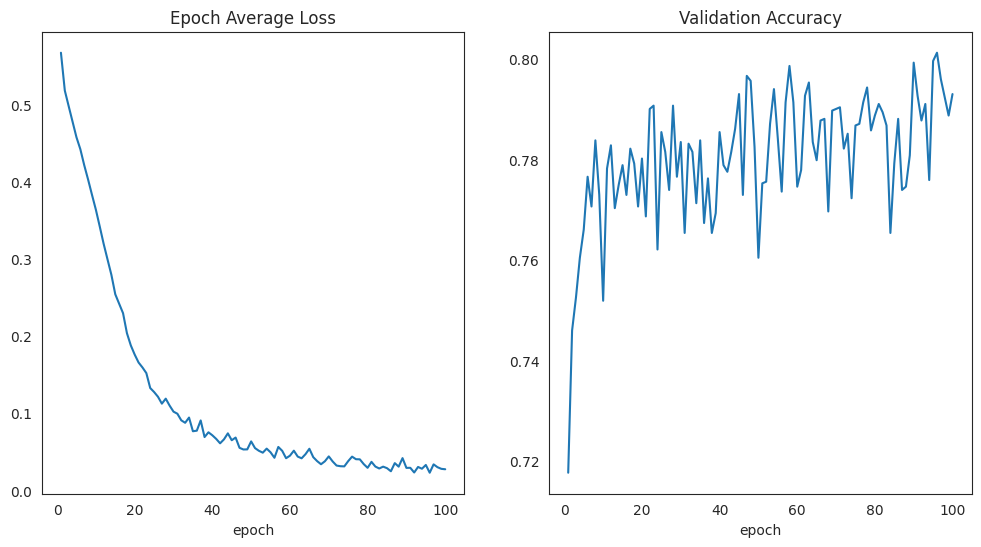

In [50]:
plt.figure("train", (12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x_train = [i + 1 for i in range(len(epoch_loss_values))]
y_train = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x_train, y_train)

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.title("Validation Accuracy")
x_val = [val_interval * (i + 1) for i in range(len(accuracy_values))]
y_val = accuracy_values
plt.xlabel("epoch")
plt.plot(x_val, y_val)

plt.show()


In [51]:


# Assuming 'root_dir' is defined as '/content/drive/MyDrive/Colab Notebooks'
root_dir = "/content/drive/MyDrive/Colab Notebooks"

# Instantiate the DenseNet121 model
model = DenseNet169(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)

# Load the saved model
saved_model_path = os.path.join(root_dir, "DenseNet169_100_best_accuracy_model.hdf5")
model.load_state_dict(torch.load(saved_model_path))
model.to(device)
model.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Perform predictions on the actual_val_loader
with torch.no_grad():
    for actual_val_data in actual_val_loader:
        actual_val_images, actual_val_labels = (
            actual_val_data[0].to(device),
            actual_val_data[1].to(device),
        )

        # Convert input images to torch.cuda.FloatTensor
        actual_val_images = actual_val_images.to(torch.float32)

        # Forward pass
        outputs = model(actual_val_images)

        # Collect true labels and predicted labels
        y_true.extend(actual_val_labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# Calculate accuracy
accuracy1 = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy1)

Accuracy: 0.7966280295047419


              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1931
           1       0.77      0.84      0.80      1865

    accuracy                           0.80      3796
   macro avg       0.80      0.80      0.80      3796
weighted avg       0.80      0.80      0.80      3796



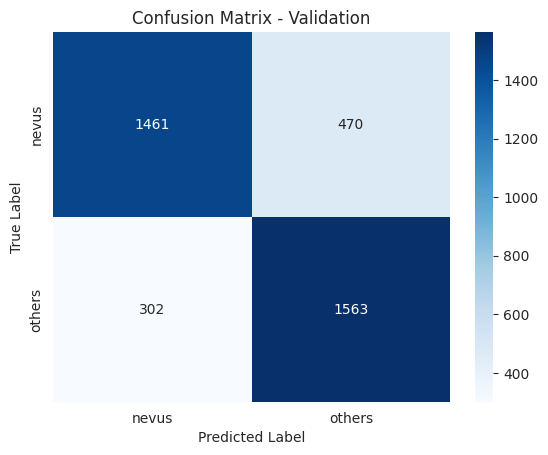

In [52]:
print(classification_report(y_true, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation')
plt.show()